In [1]:
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from kaggle_datasets import KaggleDatasets
from tensorflow import keras
from functools import partial
from sklearn.model_selection import train_test_split
print("Tensorflow version " + tf.__version__)

import tensorflow.keras.layers as L
import tensorflow.keras.backend as K

Tensorflow version 2.4.0


In [2]:
plt.rcParams["figure.figsize"] = (12,12)

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# GCS_PATH_ORI = KaggleDatasets().get_gcs_path('cassavafullrestfrecords')
# # GCS_PATH_NEW = KaggleDatasets().get_gcs_path('cldc-ds-1121-size-512')
# GCS_PATH_NEW = KaggleDatasets().get_gcs_path('cassavafullrestfrecords')
BATCH_SIZE = 16
IMAGE_SIZE = [600, 800]
# IMAGE_SIZE = [512, 512]
CLASSES = ['0', '1', '2', '3', '4']
NUM_CLASSES = len(CLASSES)
EPOCHS = 20

In [4]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.int32)# / 255.0
    return image

def read_tfrecord(example, labeled=True):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    }

    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example["image"])
    image_name = tf.cast(example["image_name"], tf.string)
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return image, label, image_name
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

def input_preprocess(image, label, image_name):
    image = tf.image.resize(image, size=IMAGE_SIZE)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=255)
    image = tf.dtypes.cast(image, tf.int32)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label, image_name

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [96]:
CHANNELS = 3

# ImageNet mean and standard deviation
# IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
# IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.uniform([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape(tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3])    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.uniform([1],dtype='float32') 
    width_shift = w_shift * tf.random.uniform([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape(tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3])

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def data_augment(image, label, image_name):
    
    HEIGHT = IMAGE_SIZE[0]
    WIDTH = IMAGE_SIZE[1]
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel = tf.random.uniform([], 0, 1.0, dtype=tf.float32)    
    p_shift = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_hue = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # Flips
    if p_spatial >= .5:
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .50:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Crops
    if p_crop > .4:
        crop_size = tf.random.uniform([], int(HEIGHT*.7), HEIGHT, dtype=tf.int32)
        image = tf.image.random_crop(image, size=[crop_size, crop_size, CHANNELS])
    elif p_crop > .7:
        if p_crop > .9:
            image = tf.image.central_crop(image, central_fraction=.7)
        elif p_crop > .8:
            image = tf.image.central_crop(image, central_fraction=.8)
        else:
            image = tf.image.central_crop(image, central_fraction=.9)
            
    image = tf.image.resize(image, size=[HEIGHT, WIDTH])
        
    # Pixel-level transforms
    if p_pixel >= .2:
        if p_pixel >= .8:
            image = tf.image.random_saturation(image, lower=0., upper=0.5)
        elif p_pixel >= .6:
            image = tf.image.random_contrast(image, lower=0., upper=0.5)
        elif p_pixel >= .4:
            image = tf.image.random_brightness(image, max_delta=.2)
        else:
            image = tf.image.adjust_gamma(image, gamma=.2)
    
    if p_hue >= 0.5:
        image = tf.image.random_hue(image, 0.3)

    return image, label, image_name

In [97]:
def get_validation_dataset(FILENAMES, BATCH_SIZE=12):
    dataset = load_dataset(FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(input_preprocess, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [98]:
TEST_FILENAMES = ['../MobileNet/full_res_TFRecords/Id_train18-1069.tfrec', 
                  '../MobileNet/full_res_TFRecords/Id_train19-1069.tfrec']

In [99]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
CLASSES = ['0', '1', '2', '3', '4']
NUM_CLASSES = len(CLASSES)

BATCH_SIZE = 36
train_dataset = get_validation_dataset(TEST_FILENAMES, BATCH_SIZE=BATCH_SIZE)

In [100]:
for image, label, filename in train_dataset.take(1):
    pass

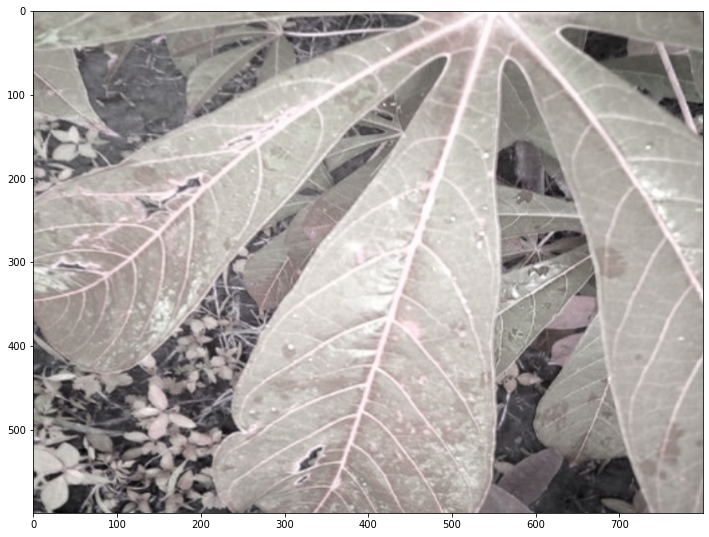

In [105]:
plt.imshow(image[1])

In [106]:
filename[1]

<tf.Tensor: shape=(), dtype=string, numpy=b'../input/train_images/1003442061.jpg'>

In [28]:
width = 800
x = tf.repeat( tf.range(width//2,-width//2,-1), width )

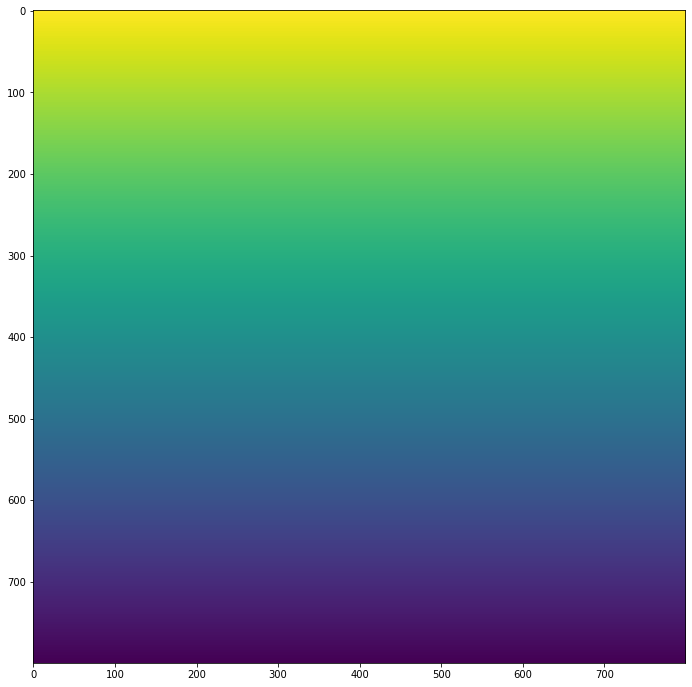

In [33]:
plt.imshow(x.numpy().reshape((800, 800)))

In [27]:
height = 600
tf.tile( tf.range(-height//2,height//2),[height] )

<tf.Tensor: shape=(360000,), dtype=int32, numpy=array([-300, -299, -298, ...,  297,  298,  299], dtype=int32)>

In [36]:
rotation = 45

rotation = rotation * tf.random.uniform([1],dtype='float32')
# CONVERT DEGREES TO RADIANS
rotation = math.pi * rotation / 180.

# ROTATION MATRIX
c1 = tf.math.cos(rotation)
s1 = tf.math.sin(rotation)
one = tf.constant([1],dtype='float32')
zero = tf.constant([0],dtype='float32')
rotation_matrix = tf.reshape(tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3])

In [37]:
rotation_matrix

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.935629  ,  0.35298488,  0.        ],
       [-0.35298488,  0.935629  ,  0.        ],
       [ 0.        ,  0.        ,  1.        ]], dtype=float32)>